  Cloning https://github.com/openai/whisper.git to /tmp/pip-req-build-0ls8tlce
  Running command git clone --filter=blob:none --quiet https://github.com/openai/whisper.git /tmp/pip-req-build-0ls8tlce
  Resolved https://github.com/openai/whisper.git to commit c0d2f624c09dc18e709e37c2ad90c039a4eb72a2
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


100%|██████████| 309/309 [07:38<00:00,  1.48s/it]



 overall accuracy: 96.77%
 pass threshold 

 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         2
           8       1.00      1.00      1.00         3
           9       0.67      0.67      0.67         3
          10       1.00      1.00      1.00         2
          11       1.00      1.00      1.00         2
          12       1.00      1.00      1.00         3
          13       1.00      1.00      1.00         3
          14       1.00      1.00      1.00         2
          15       1.00      1.00      1.00         2
          16       1.00      1.00      1.00         3
          17

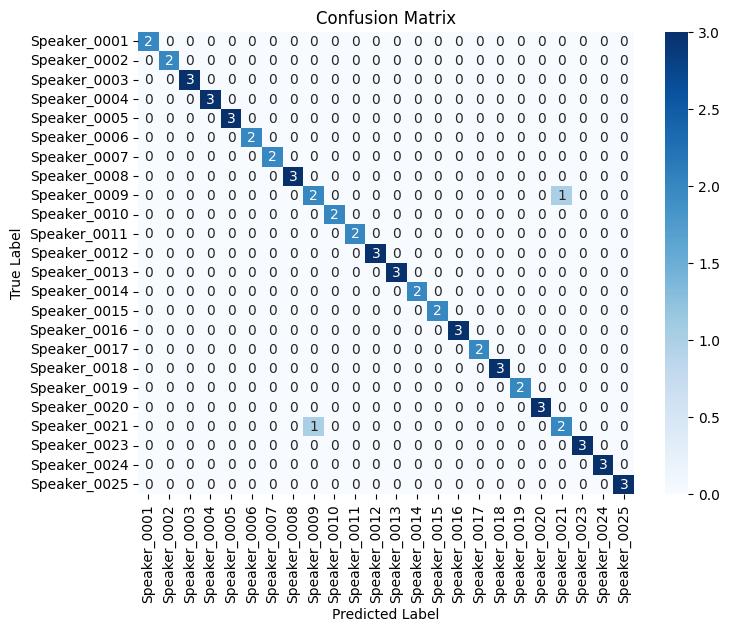


 Accuracy by User:
user
Speaker_0001    1.000000
Speaker_0002    1.000000
Speaker_0004    1.000000
Speaker_0005    1.000000
Speaker_0006    1.000000
Speaker_0007    1.000000
Speaker_0008    1.000000
Speaker_0009    1.000000
Speaker_0010    0.666667
Speaker_0011    1.000000
Speaker_0012    1.000000
Speaker_0013    1.000000
Speaker_0014    1.000000
Speaker_0015    1.000000
Speaker_0016    1.000000
Speaker_0017    1.000000
Speaker_0018    1.000000
Speaker_0019    1.000000
Speaker_0020    1.000000
Speaker_0021    1.000000
Speaker_0023    0.666667
Speaker_0024    1.000000
Speaker_0025    1.000000
Name: correct, dtype: float64

 Total processing time: 467.63 seconds


In [3]:
#OPENAI WHISPER

!pip install git+https://github.com/openai/whisper.git
!pip install torchaudio scikit-learn matplotlib seaborn

import os
import zipfile
import time
import torch
import whisper
import torchaudio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
)

model = whisper.load_model("base")


def get_whisper_embedding(path):
    audio = whisper.load_audio(path)
    audio = whisper.pad_or_trim(audio)
    mel = whisper.log_mel_spectrogram(audio).to(model.device)
    with torch.no_grad():
        return model.encoder(mel.unsqueeze(0)).mean(dim=1).cpu().numpy().squeeze()

def build_dataset(base_dir):
    users = os.listdir(base_dir)
    data = []
    for uid, user in enumerate(users):
        user_dir = os.path.join(base_dir, user)
        if not os.path.isdir(user_dir):  # Skip if not a directory
            continue
        files = sorted(os.listdir(user_dir))[:14]
        for f in files:
            if f.endswith(".wav"):
                data.append({"path": os.path.join(user_dir, f), "label": uid, "user": user})
    return pd.DataFrame(data)


DATA_DIR = "/content/25_speakers_audio_data"
df = build_dataset(DATA_DIR)

start_time = time.time()

#embeddings
embeddings, labels, user_ids = [], [], []
for _, row in tqdm(df.iterrows(), total=len(df)):
    emb = get_whisper_embedding(row["path"])
    embeddings.append(emb)
    labels.append(row["label"])
    user_ids.append(row["user"])

X = np.vstack(embeddings)
y = np.array(labels)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

#classifier train
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

#end time
end_time = time.time()
elapsed_time = end_time - start_time

#eval accuracy
acc = accuracy_score(y_test, y_pred)
print(f"\n overall accuracy: {acc:.2%}")
print(" pass threshold " if acc >= 0.70 else " Below threshold ")
print("\n Classification Report:")
print(classification_report(y_test, y_pred))

#confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=sorted(set(user_ids)),
            yticklabels=sorted(set(user_ids)))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Per-user accuracy
user_label_map = {i: user for i, user in enumerate(sorted(set(user_ids)))}
df_test = pd.DataFrame({'true': y_test, 'pred': y_pred})
df_test['user'] = df_test['true'].map(user_label_map)
df_test['correct'] = df_test['true'] == df_test['pred']
user_accuracy = df_test.groupby('user')['correct'].mean()
print("\n Accuracy by User:")
print(user_accuracy)

# Time taken
print(f"\n Total processing time: {elapsed_time:.2f} seconds")

In [1]:
!unzip /content/25_speakers_audio_data.zip

Archive:  /content/25_speakers_audio_data.zip
   creating: 50_speakers_audio_data/
  inflating: __MACOSX/._50_speakers_audio_data  
  inflating: 50_speakers_audio_data/.DS_Store  
  inflating: __MACOSX/50_speakers_audio_data/._.DS_Store  
   creating: 50_speakers_audio_data/Speaker_0006/
  inflating: __MACOSX/50_speakers_audio_data/._Speaker_0006  
   creating: 50_speakers_audio_data/Speaker_0001/
  inflating: __MACOSX/50_speakers_audio_data/._Speaker_0001  
   creating: 50_speakers_audio_data/Speaker_0008/
  inflating: __MACOSX/50_speakers_audio_data/._Speaker_0008  
   creating: 50_speakers_audio_data/Speaker_0009/
  inflating: __MACOSX/50_speakers_audio_data/._Speaker_0009  
   creating: 50_speakers_audio_data/Speaker_0007/
  inflating: __MACOSX/50_speakers_audio_data/._Speaker_0007  
   creating: 50_speakers_audio_data/Speaker_0025/
  inflating: __MACOSX/50_speakers_audio_data/._Speaker_0025  
   creating: 50_speakers_audio_data/Speaker_0014/
  inflating: __MACOSX/50_speakers_audio